In [1]:
# Importing standard python libraries
import numpy as np
from math import pi, sqrt
import matplotlib.pyplot as plt

# Importing standard Qiskit libraries
from qiskit import QuantumCircuit, transpile, Aer, IBMQ, execute, QuantumRegister
from qiskit.tools.jupyter import *
from qiskit.visualization import * # plot_bloch_multivector
from ibm_quantum_widgets import * # CircuitComposer
from qiskit.providers.aer import QasmSimulator
from qiskit.quantum_info import Statevector

# Loading your IBM Quantum account(s)
provider = IBMQ.load_account()

<frozen importlib._bootstrap>:219: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject


In [2]:
# Start with a 2-qubit quantum circuit (Bell state + a rotation) yielding a nice fractal. Change the circuit as you like.
circuit = QuantumCircuit(2,2)
circuit.h(0)
circuit.cx(0,1)
circuit.u(pi/4, -pi/3, pi/8, 1)
editor2 = CircuitComposer(circuit=circuit)
editor2

CircuitComposer(circuit=<qiskit.circuit.quantumcircuit.QuantumCircuit object at 0x7f1fc4132bb0>)

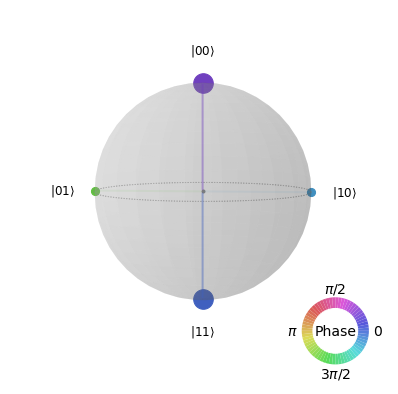

In [3]:
# View the circiut quantum state on the qshere
qc2 = editor2.circuit
plot_state_qsphere(qc2)

z =  (-0.71+0.7j)


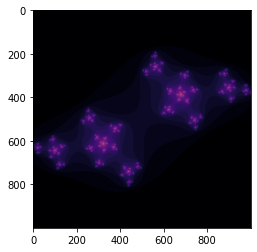

In [4]:
# Run the circuit with the state vector simulator to obtain a noise-free fractal.
qc2 = editor2.circuit
backend = Aer.get_backend('statevector_simulator')
out = execute(qc2,backend).result().get_statevector()
#print(out)

# Obtain the four complex amplitudes from the state vector
a00 = out.data[0]
a01 = out.data[1]
a10 = out.data[2]
a11 = out.data[3]

# Goal: One complex number for the Julia set fractal. 
# Divide a00 with a11 - which may indicate entanglement.
if a11.real != 0 or a11.imag != 0:
    z1 = a00/a11
    z1 = round(z1.real, 2) + round(z1.imag, 2) * 1j
else:
     z1 = 0

# Divide a01 with a10.
if a10.real != 0 or a10.imag != 0:
    z2 = a01/a10
    z2 = round(z2.real, 2) + round(z2.imag, 2) * 1j
else:
     z2 = 0

# Obtain the complex number for the Julia set fractal.
if z2.real != 0 or z2.imag != 0:
    z = z1/z2 # (z1+z2)/2
    z = round(z.real, 2) + round(z.imag, 2) * 1j
else:
     z = 0
        
print("z = ",z)


# Define the size
size = 1000
heightsize = size
widthsize = size


def julia_set(c=z, height=heightsize, width=widthsize, x=0, y=0, zoom=1, max_iterations=100):
    
    # To make navigation easier we calculate these values
    x_width = 1.5
    y_height = 1.5*height/width
    x_from = x - x_width/zoom
    x_to = x + x_width/zoom
    y_from = y - y_height/zoom
    y_to = y + y_height/zoom
    
    # Here the actual algorithm starts and the z paramter is defined for the Julia set function
    x = np.linspace(x_from, x_to, width).reshape((1, width))
    y = np.linspace(y_from, y_to, height).reshape((height, 1))
    z = x + 1j * y
    
    # Initialize c to the complex number obtained from the quantum circuit
    c = np.full(z.shape, c)
    
    # To keep track in which iteration the point diverged
    div_time = np.zeros(z.shape, dtype=int)
    
    # To keep track on which points did not converge so far
    m = np.full(c.shape, True, dtype=bool)
    
    for i in range(max_iterations):
        z[m] = z[m]**2 + c[m]
        m[np.abs(z) > 2] = False
        div_time[m] = i
    return div_time



# plot the Julia set fractal
plt.imshow(julia_set(), cmap='magma') # viridis', 'plasma', 'inferno', 'magma', 'cividis'
plt.show()

## Running on a real quantum computer
### Identify the least busy system, perform measurements and run on the backend

In [5]:
# Find the least busy system that has at least 2 qubits
from qiskit.providers.ibmq import least_busy

ibmq_backend = least_busy(provider.backends(filters=lambda x: x.configuration().n_qubits >= 2 and 
                                   not x.configuration().simulator and x.status().operational==True))

print("The least busy quantum computer now is",ibmq_backend)

The least busy quantum computer now is ibmq_belem


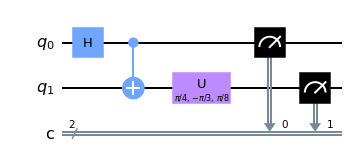

In [6]:
# Add measurements - used to calculate the modified state vector
qc2.measure([0,1], [0,1])
qc2.draw()

In [10]:
# Define the number of shots for the execution. 
shotno=1024

# Run the circuit on a real quantum computer. NB! This may take a while.
job_ibmq = execute(qc2, ibmq_backend, shots=shotno)
result = job_ibmq.result()

## Perform calculations and plot results

z,zqc =  (-0.71+0.7j) (-0.942+0.942j)


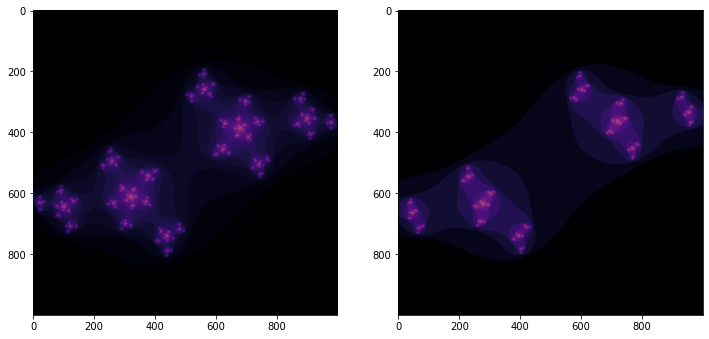

In [12]:
# Get the state vector probabilities
prob00statevec = out.probabilities()[0]
prob01statevec = out.probabilities()[1]
prob10statevec = out.probabilities()[2]
prob11statevec = out.probabilities()[3]
#print("Statevector probilities of measuring the basis states: ", round(prob00statevec,3), round(prob01statevec,3), round(prob10statevec,3),round(prob11statevec,3))

# Calculate the probabilities for each basis state based on the count results
counts = result.get_counts()
prob00qc = counts['00']/shotno
prob01qc = counts['01']/shotno
prob10qc = counts['10']/shotno
prob11qc = counts['11']/shotno
#print("Observed probabilities of measuring the computational basis states", round(prob00qc,3), round(prob01qc,3),round(prob10qc,3),round(prob11qc,3))


# One simple approach to obtain the modified state vector basis states # amplitude^2 = probability
a00qc = a00*sqrt(prob00qc/prob00statevec)
a01qc = a01*sqrt(prob01qc/prob01statevec)
a10qc = a10*sqrt(prob10qc/prob10statevec)
a11qc = a11*sqrt(prob11qc/prob11statevec)

# Calculate the quantum computer-modified complex parameter zqc. 
z1qc = a00qc/a11qc
z2qc = a01qc/a10qc
zqc = z1qc/z2qc
print("z,zqc = ",z,np.round(zqc,3))

# Plot both Julia set fractals for comparison - the simulator based on the left and the modified on the right 
f, axarr = plt.subplots(1,2,figsize=(12, 12))
axarr[0].imshow(julia_set(c=z), cmap='magma')
axarr[1].imshow(julia_set(c=zqc), cmap='magma')